# CNN cross-validation demo (3 days -> 1 day)

This notebook demonstrates: 
- loading preprocessed windows from `DataProcessor` (3 days input -> 1 day output),
- selecting the 4 sub-metering channels as multi-channel input,
- building time-series folds with `TimeSeriesSplit`,
- running cross-validation training using `cnn_model_yin.CNN` and `cross_validate`,
- plotting per-fold train/val loss and evaluating on the test set.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from cnn_model_yin import CNN, cross_validate, train
import torch
import torch.nn as nn
import random
import os, sys

# load data through the data preprocessor
sys.path.append(os.path.abspath('..'))  # add parent directory to sys.path
from data_cleanup import DataProcessor

# Reproducibility (best-effort)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
# Instantiate DataProcessor for 3 days -> 1 day
INPUT_STEPS = 24 * 3  # 72 hours
OUTPUT_STEPS = 24 # 24 hours
processor = DataProcessor(input_steps=INPUT_STEPS, output_steps=OUTPUT_STEPS,local_raw_path='../raw-consumption-data.zip')

# This will fetch, clean, resample and window the data (may take a moment)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = processor.load_and_process_data()

print('Shapes:')
print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

Step 1/5: Fetching, cleaning, and engineering features...


e:\ywc_college\junior1\notebook\Machine Learning\pj\ECS171G13\data_cleanup.py:132: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
e:\ywc_college\junior1\notebook\Machine Learning\pj\ECS171G13\data_cleanup.py:172: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').agg(agg_dict)


Step 2/5: Resampling data to hourly and setting 'Global_active_power' as target...
Step 3/5: Splitting data and applying scaler...
Step 4/5: Creating time-series windows...
Step 5/5: Data processing complete.
Shapes:
X_train (25832, 72, 8) y_train (25832, 24)
X_val (3529, 72, 8) y_val (3529, 24)
X_test (4943, 72, 8) y_test (4943, 24)
Step 3/5: Splitting data and applying scaler...
Step 4/5: Creating time-series windows...
Step 5/5: Data processing complete.
Shapes:
X_train (25832, 72, 8) y_train (25832, 24)
X_val (3529, 72, 8) y_val (3529, 24)
X_test (4943, 72, 8) y_test (4943, 24)


e:\ywc_college\junior1\notebook\Machine Learning\pj\ECS171G13\data_cleanup.py:173: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly = df_hourly.fillna(method='ffill')


In [3]:
# Select the 4 sub-metering channels as input channels
# Based on data_cleanup.py ordering, expected columns after reorder are:
# [Global_active_power, Global_reactive_power, Voltage, Global_intensity,
#  Sub_metering_1, Sub_metering_2, Sub_metering_3, Sub_metering_rest]
# So sub-metering channel indices (0-based) are 4..7
channel_indices = [4,5,6,7]
n_features = X_train.shape[2]
assert max(channel_indices) < n_features, 'Channel indices out of range for X_train features'

X_train_ch = X_train[:, :, channel_indices]  # shape (n_samples, time, 4)
X_val_ch   = X_val[:, :, channel_indices]
X_test_ch  = X_test[:, :, channel_indices]

print('Selected channel shapes:')
print('X_train_ch', X_train_ch.shape, 'y_train', y_train.shape)

Selected channel shapes:
X_train_ch (25832, 72, 4) y_train (25832, 24)


In [4]:
# Create TimeSeriesSplit folds from the training windows (time-aware)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
folds = []
for train_idx, val_idx in tscv.split(X_train_ch):
    Xtr = X_train_ch[train_idx]
    ytr = y_train[train_idx]
    Xval = X_train_ch[val_idx]
    yval = y_train[val_idx]
    folds.append(((Xtr, ytr), (Xval, yval)))

print(f'Constructed {len(folds)} folds. Example fold shapes:')
print('fold0 train X', folds[0][0][0].shape, 'y', folds[0][0][1].shape, 'val X', folds[0][1][0].shape)

Constructed 5 folds. Example fold shapes:
fold0 train X (4307, 72, 4) y (4307, 24) val X (4305, 72, 4)


In [5]:
# Define model factory (callable returning a fresh model)
def make_model():
    return CNN(in_channels=4, input_length=INPUT_STEPS, output_steps=OUTPUT_STEPS)

In [6]:
# Run cross-validation quickly (small epochs for demo) WITH checkpoint saving
histories, val_losses, test_model = cross_validate(
    make_model,
    folds,
    device=None,
    epochs=3,
    batch_size=32,
    lr=1e-3,
    verbose=True,
    checkpoint_dir='checkpoint/cv_demo',
    save_best_only=True
)
print('Per-fold final val losses:', val_losses)
print('Best per-fold checkpoint directories saved under: checkpoint/cv_demo/')

Starting fold 1/5: train (4307, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.028640 - val_loss: 0.020585
Epoch 1/3 - train_loss: 0.028640 - val_loss: 0.020585
Epoch 2/3 - train_loss: 0.026916 - val_loss: 0.019387
Epoch 2/3 - train_loss: 0.026916 - val_loss: 0.019387
Epoch 3/3 - train_loss: 0.024278 - val_loss: 0.016421
Starting fold 2/5: train (8612, 72, 4) | val (4305, 72, 4)
Epoch 3/3 - train_loss: 0.024278 - val_loss: 0.016421
Starting fold 2/5: train (8612, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.024025 - val_loss: 0.021263
Epoch 1/3 - train_loss: 0.024025 - val_loss: 0.021263
Epoch 2/3 - train_loss: 0.019081 - val_loss: 0.017467
Epoch 2/3 - train_loss: 0.019081 - val_loss: 0.017467
Epoch 3/3 - train_loss: 0.017109 - val_loss: 0.016957
Starting fold 3/5: train (12917, 72, 4) | val (4305, 72, 4)
Epoch 3/3 - train_loss: 0.017109 - val_loss: 0.016957
Starting fold 3/5: train (12917, 72, 4) | val (4305, 72, 4)
Epoch 1/3 - train_loss: 0.021404 - val_loss: 0.013400
E

In [7]:
# Final full training on all training windows + validation, save best checkpoint
# (Separate from cross-validation demonstration.)
import os
os.makedirs('checkpoint/run1', exist_ok=True)
final_hist = train(
    make_model(),
    X_train_ch,
    y_train,
    X_val=X_val_ch,
    y_val=y_val,
    device=None,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    verbose=True,
    checkpoint_dir='checkpoint/run1',
    checkpoint_prefix='final',
    save_best_only=True
)
print('Final training best val loss:', final_hist['best_val_loss'])
print('Best checkpoint path:', final_hist['checkpoint_path'])

# Load best model for test evaluation
best_model = make_model()
if final_hist['checkpoint_path']:
    ckpt = torch.load(final_hist['checkpoint_path'], map_location='cpu')
    best_model.load_state_dict(ckpt['model_state_dict'])

# Evaluate on test set (ensure tensor shapes and device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)
best_model.eval()

with torch.no_grad():
    Xt = torch.tensor(X_test_ch, dtype=torch.float32).to(device)
    if Xt.ndim == 3 and Xt.shape[2] == 4 and Xt.shape[1] != 4:
        Xt = Xt.permute(0, 2, 1)
    preds = best_model(Xt)
    yt = torch.tensor(y_test, dtype=torch.float32).to(device)
    preds_np = preds.cpu().numpy()
    yt_np = yt.cpu().numpy()

# Inverse-transform each horizon step separately back to original units using the processor's scaler
preds_un = np.zeros_like(preds_np)
yt_un = np.zeros_like(yt_np)
for t in range(preds_np.shape[1]):
    try:
        preds_un[:, t] = processor.inverse_transform_predictions(preds_np[:, t])
        yt_un[:, t] = processor.inverse_transform_predictions(yt_np[:, t])
    except Exception as e:
        print('Warning: inverse transform failed for horizon step', t, '-> plotting scaled values. Error:', e)
        preds_un[:, t] = preds_np[:, t]
        yt_un[:, t] = yt_np[:, t]

Epoch 1/10 - train_loss: 0.016528 - val_loss: 0.013187
Epoch 2/10 - train_loss: 0.013821 - val_loss: 0.012699
Epoch 2/10 - train_loss: 0.013821 - val_loss: 0.012699
Epoch 3/10 - train_loss: 0.013184 - val_loss: 0.012580
Epoch 3/10 - train_loss: 0.013184 - val_loss: 0.012580
Epoch 4/10 - train_loss: 0.012850 - val_loss: 0.012501
Epoch 4/10 - train_loss: 0.012850 - val_loss: 0.012501
Epoch 5/10 - train_loss: 0.012590 - val_loss: 0.012503
Epoch 5/10 - train_loss: 0.012590 - val_loss: 0.012503
Epoch 6/10 - train_loss: 0.012393 - val_loss: 0.012455
Epoch 6/10 - train_loss: 0.012393 - val_loss: 0.012455
Epoch 7/10 - train_loss: 0.012065 - val_loss: 0.012507
Epoch 7/10 - train_loss: 0.012065 - val_loss: 0.012507
Epoch 8/10 - train_loss: 0.011841 - val_loss: 0.012562
Epoch 8/10 - train_loss: 0.011841 - val_loss: 0.012562
Epoch 9/10 - train_loss: 0.011580 - val_loss: 0.012655
Epoch 9/10 - train_loss: 0.011580 - val_loss: 0.012655
Epoch 10/10 - train_loss: 0.011332 - val_loss: 0.012805
Final tra

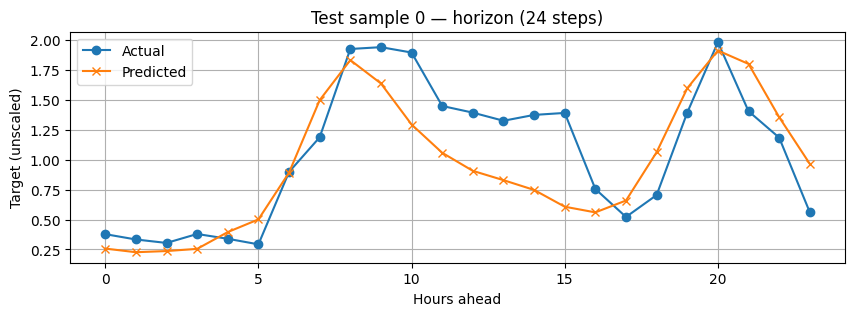

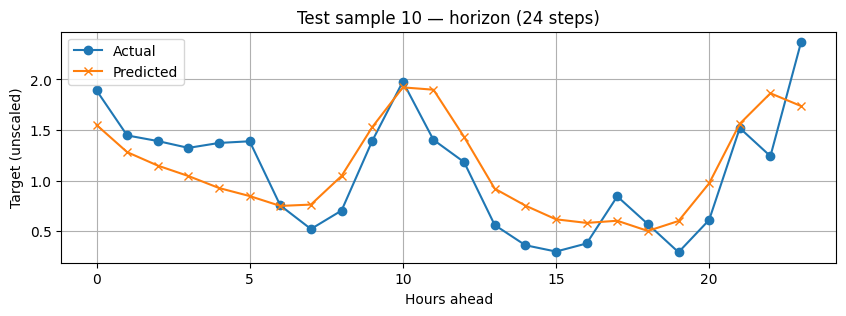

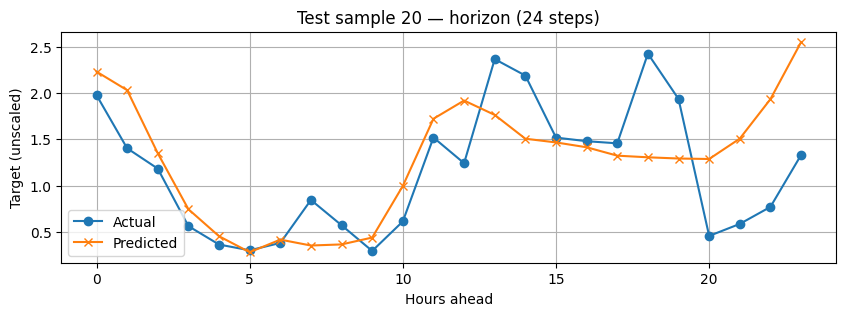

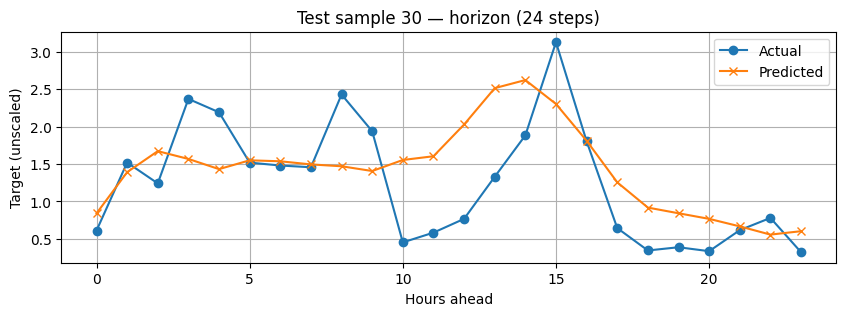

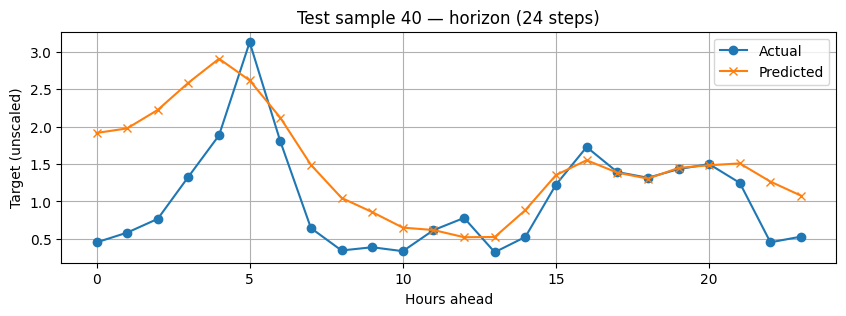

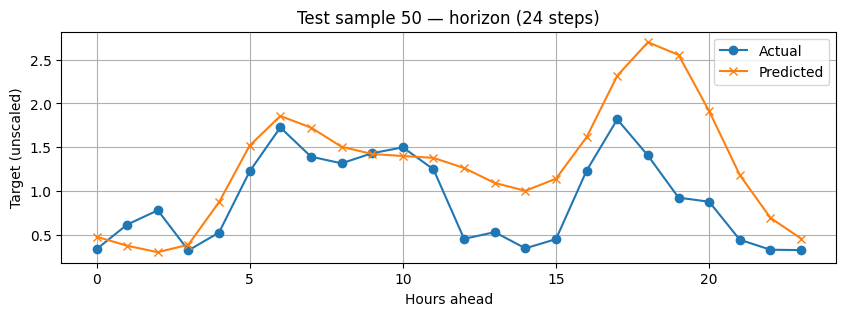

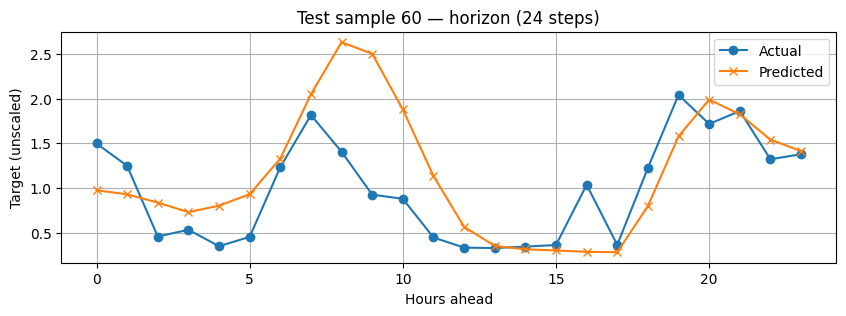

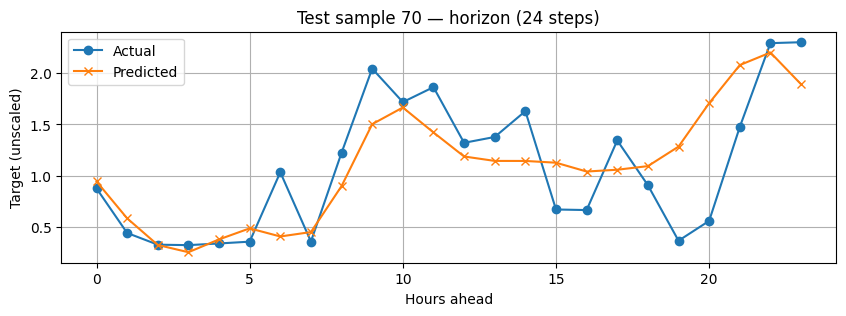

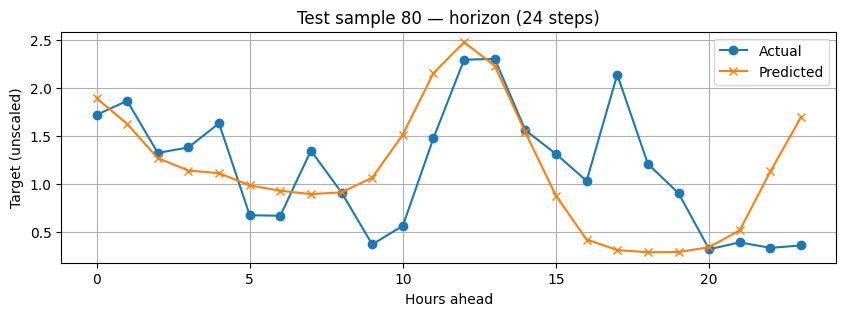

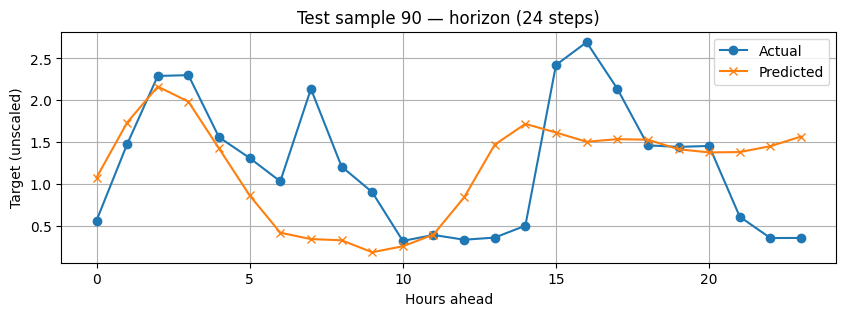

Final test MSE (unscaled, all horizons): 0.396882


In [8]:
# Plot the first K test samples comparing predicted vs actual across the horizon
K = 100
import matplotlib.pyplot as plt
for i in range(0,min(K, preds_un.shape[0]),10):
    plt.figure(figsize=(10, 3))
    plt.plot(range(preds_un.shape[1]), yt_un[i], marker='o', label='Actual')
    plt.plot(range(preds_un.shape[1]), preds_un[i], marker='x', label='Predicted')
    plt.title(f'Test sample {i} — horizon ({preds_un.shape[1]} steps)')
    plt.xlabel('Hours ahead')
    plt.ylabel('Target (unscaled)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Numeric summary (unscaled MSE across all horizons)
mse_unscaled = np.mean((preds_un - yt_un)**2)
print(f'Final test MSE (unscaled, all horizons): {mse_unscaled:.6f}')

Notes:
- This demo uses small epoch counts so it runs quickly; increase epochs for serious training.
- If your DataProcessor used different column ordering or unit scaling, adjust `channel_indices`.

## Integrated cross-validation analysis

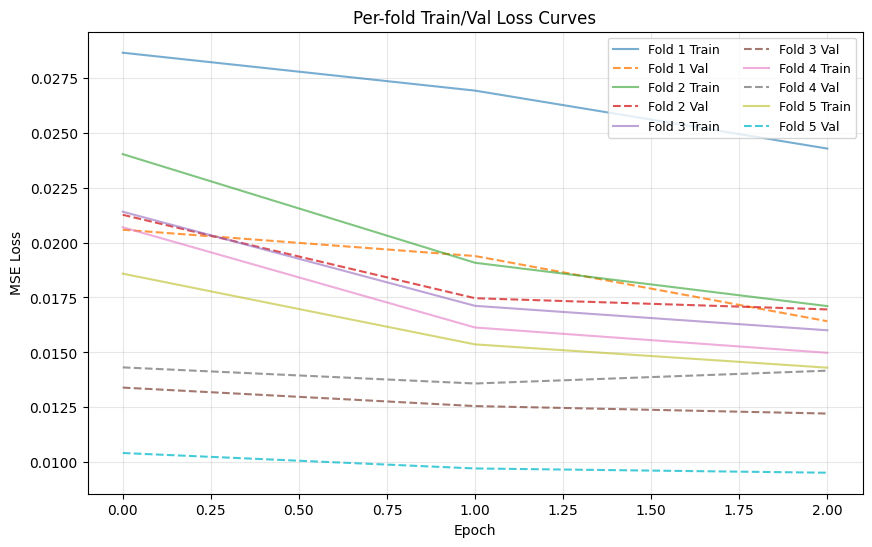

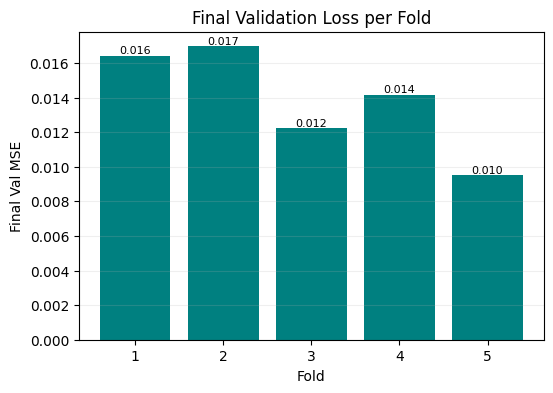

CV Best Model Test MSE (overall): 0.3640611171722412
Baseline Final Model Test MSE (overall): 0.3968818485736847
CV Daily Sum MSE: 46.78158950805664
Baseline Daily Sum MSE: 53.51390838623047
CV MAE: 0.46477147936820984 Baseline MAE: 0.48540300130844116
CV SMAPE: 0.5213133692741394 Baseline SMAPE: 0.5221942067146301


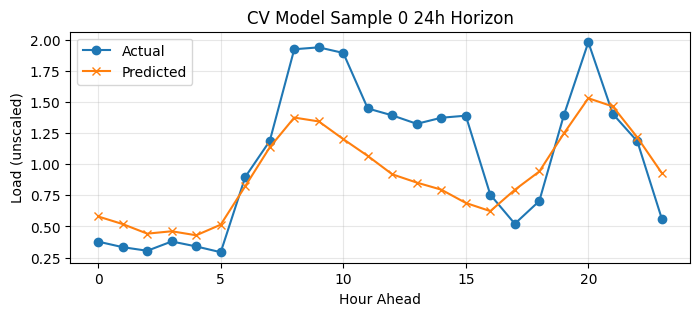

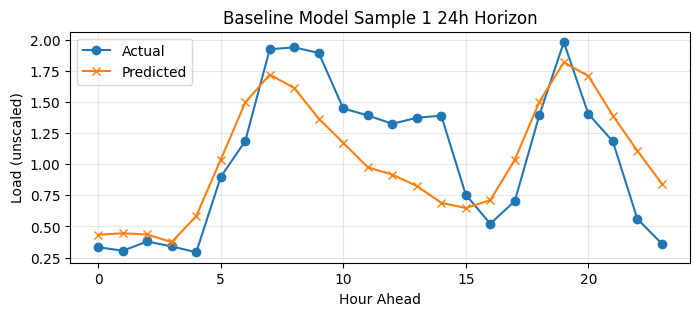

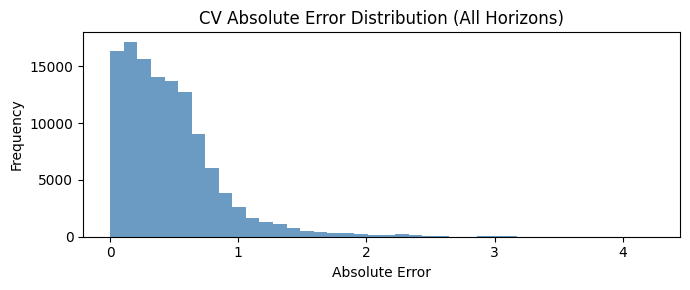

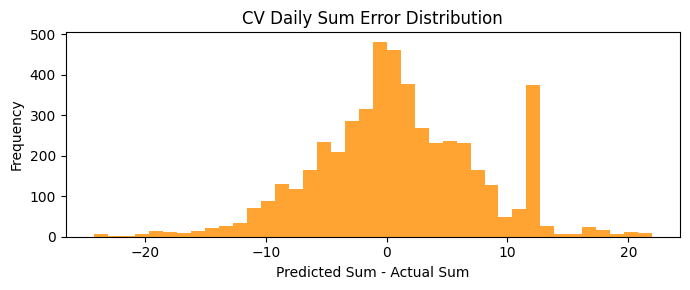

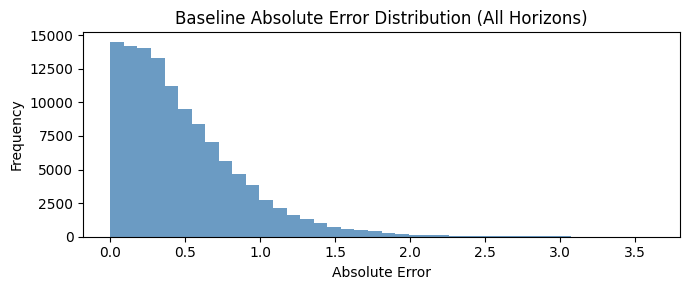

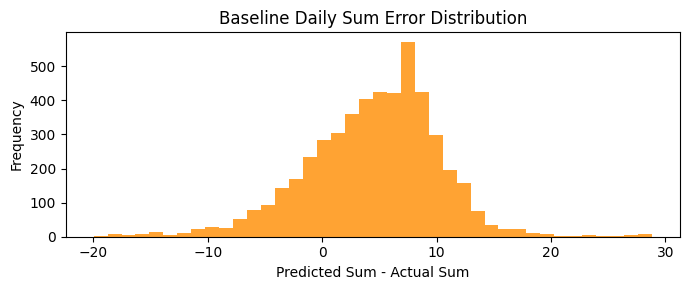

Saved summary metrics to cv_demo_summary_metrics.json


{'cv_final_val_losses': [0.01642111875116825,
  0.01695733703672886,
  0.012217617593705654,
  0.014169239439070225,
  0.009525117464363575],
 'cv': {'mse_all': 0.3640611171722412,
  'mse_daily_sum': 46.78158950805664,
  'mae_all': 0.46477147936820984,
  'mape_all': 0.8176025748252869,
  'smape_all': 0.5213133692741394},
 'baseline': {'mse_all': 0.3968818485736847,
  'mse_daily_sum': 53.51390838623047,
  'mae_all': 0.48540300130844116,
  'mape_all': 0.8820186257362366,
  'smape_all': 0.5221942067146301}}

In [ ]:
# Uses existing variables: histories, val_losses, test_model (CV best), best_model (baseline full training),
# processor, X_test_ch, y_test
import torch, numpy as np, matplotlib.pyplot as plt, os, json

# 1. Plot per-fold train/val loss curves
plt.figure(figsize=(10,6))
for i, hist in enumerate(histories, start=1):
    plt.plot(hist['train_loss'], label=f'Fold {i} Train', alpha=0.6)
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label=f'Fold {i} Val', linestyle='--', alpha=0.8)
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title('Per-fold Train/Val Loss Curves')
plt.legend(ncol=2, fontsize=9); plt.grid(alpha=0.3); plt.show()

# 2. Bar chart of final validation losses
plt.figure(figsize=(6,4))
plt.bar(range(1, len(val_losses)+1), val_losses, color='teal')
plt.xlabel('Fold'); plt.ylabel('Final Val MSE'); plt.title('Final Validation Loss per Fold')
for i,v in enumerate(val_losses, start=1):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
plt.grid(axis='y', alpha=0.2)
plt.show()

# 3. Helper: evaluation on test set (unscaled if inverse transform available)

def evaluate_model(model, X_test_ch, y_test, processor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        Xt = torch.tensor(X_test_ch, dtype=torch.float32).to(device)
        if Xt.ndim == 3 and Xt.shape[2] == 4 and Xt.shape[1] != 4:
            Xt = Xt.permute(0,2,1)
        preds = model(Xt)
        yt = torch.tensor(y_test, dtype=torch.float32).to(device)
        preds_np = preds.cpu().numpy(); yt_np = yt.cpu().numpy()
    preds_un = np.zeros_like(preds_np); yt_un = np.zeros_like(yt_np)
    for t in range(preds_np.shape[1]):
        try:
            preds_un[:, t] = processor.inverse_transform_predictions(preds_np[:, t])
            yt_un[:, t] = processor.inverse_transform_predictions(yt_np[:, t])
        except Exception:
            preds_un[:, t] = preds_np[:, t]; yt_un[:, t] = yt_np[:, t]
    mse_all = float(np.mean((preds_un - yt_un)**2))
    mse_per_horizon = np.mean((preds_un - yt_un)**2, axis=0)
    pred_sum = preds_un.sum(axis=1); actual_sum = yt_un.sum(axis=1)
    mse_daily_sum = float(np.mean((pred_sum - actual_sum)**2))
    return {
        'mse_all': mse_all,
        'mse_per_horizon': mse_per_horizon,
        'mse_daily_sum': mse_daily_sum,
        'preds_un': preds_un,
        'yt_un': yt_un
    }

# 4. Evaluate CV best model (test_model) and baseline (best_model)
cv_metrics = evaluate_model(test_model, X_test_ch, y_test, processor)
baseline_metrics = evaluate_model(best_model, X_test_ch, y_test, processor)

# 5. Additional metrics (MAE, MAPE, SMAPE)
EPS = 1e-8
for name, metrics in [('CV', cv_metrics), ('Baseline', baseline_metrics)]:
    err = metrics['preds_un'] - metrics['yt_un']
    mae = np.mean(np.abs(err))
    mape = np.mean(np.abs(err) / (np.abs(metrics['yt_un']) + EPS))
    smape = np.mean(2*np.abs(err) / (np.abs(metrics['preds_un']) + np.abs(metrics['yt_un']) + EPS))
    metrics['mae_all'] = float(mae)
    metrics['mape_all'] = float(mape)
    metrics['smape_all'] = float(smape)
    # per-horizon versions
    metrics['mae_per_horizon'] = np.mean(np.abs(err), axis=0).tolist()
    metrics['mape_per_horizon'] = np.mean(np.abs(err) / (np.abs(metrics['yt_un']) + EPS), axis=0).tolist()
    metrics['smape_per_horizon'] = np.mean(2*np.abs(err) / (np.abs(metrics['preds_un']) + np.abs(metrics['yt_un']) + EPS), axis=0).tolist()

print('CV Best Model Test MSE (overall):', cv_metrics['mse_all'])
print('Baseline Final Model Test MSE (overall):', baseline_metrics['mse_all'])
print('CV Daily Sum MSE:', cv_metrics['mse_daily_sum'])
print('Baseline Daily Sum MSE:', baseline_metrics['mse_daily_sum'])
print('CV MAE:', cv_metrics['mae_all'], 'Baseline MAE:', baseline_metrics['mae_all'])
print('CV SMAPE:', cv_metrics['smape_all'], 'Baseline SMAPE:', baseline_metrics['smape_all'])

# 6. Plot sample forecasts for comparison
for name, metrics, idx in [('CV', cv_metrics, 0), ('Baseline', baseline_metrics, 1)]:
    if idx < metrics['preds_un'].shape[0]:
        plt.figure(figsize=(8,3))
        plt.plot(metrics['yt_un'][idx], marker='o', label='Actual')
        plt.plot(metrics['preds_un'][idx], marker='x', label='Predicted')
        plt.title(f'{name} Model Sample {idx} 24h Horizon')
        plt.xlabel('Hour Ahead'); plt.ylabel('Load (unscaled)')
        plt.legend(); plt.grid(alpha=0.3); plt.show()

# 7. Error distribution plots
for name, metrics in [('CV', cv_metrics), ('Baseline', baseline_metrics)]:
    err = metrics['preds_un'] - metrics['yt_un']
    abs_err = np.abs(err).ravel()
    plt.figure(figsize=(7,3))
    plt.hist(abs_err, bins=40, color='steelblue', alpha=0.8)
    plt.title(f'{name} Absolute Error Distribution (All Horizons)')
    plt.xlabel('Absolute Error'); plt.ylabel('Frequency'); plt.tight_layout(); plt.show()
    # Daily sum error distribution
    daily_err = metrics['preds_un'].sum(axis=1) - metrics['yt_un'].sum(axis=1)
    plt.figure(figsize=(7,3))
    plt.hist(daily_err, bins=40, color='darkorange', alpha=0.8)
    plt.title(f'{name} Daily Sum Error Distribution')
    plt.xlabel('Predicted Sum - Actual Sum'); plt.ylabel('Frequency'); plt.tight_layout(); plt.show()

# 8. Save summary JSON inline
summary = {
    'cv_final_val_losses': val_losses,
    'cv': {
        'mse_all': cv_metrics['mse_all'],
        'mse_daily_sum': cv_metrics['mse_daily_sum'],
        'mae_all': cv_metrics['mae_all'],
        'mape_all': cv_metrics['mape_all'],
        'smape_all': cv_metrics['smape_all']
    },
    'baseline': {
        'mse_all': baseline_metrics['mse_all'],
        'mse_daily_sum': baseline_metrics['mse_daily_sum'],
        'mae_all': baseline_metrics['mae_all'],
        'mape_all': baseline_metrics['mape_all'],
        'smape_all': baseline_metrics['smape_all']
    }
}
with open('cv_demo_summary_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)
print('Saved summary metrics to cv_demo_summary_metrics.json')
summary